In [1]:
# import basic packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import self-defined modules
from implementations import *
from tools import *
from helpers import *

# just to ingore warning
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# Models Training

## 1. Load Training Data

In [2]:
# load train and test data
data_path_tr = 'data/train.csv'
yb_tr, data_tr, idx_tr, labels = load_csv_data(data_path_tr, sub_sample=False)

# prepare the data using self-defined DataFrame class
labels_dataframe = ['Prediction'] + labels
data_tr_dataframe = np.concatenate((yb_tr.reshape([-1,1]), data_tr), axis=1)
dataframe_tr = DataFrame(data_tr_dataframe, idx_tr.tolist(), labels_dataframe)

In [3]:
data_path_te = 'data/test.csv'
yb_te, data_te, idx_te, _ = load_csv_data(data_path_te, sub_sample=False)
data_te_dataframe = np.concatenate((yb_te.reshape([-1,1]), data_te), axis=1)
dataframe_te = DataFrame(data_te_dataframe, idx_tr.tolist(), labels_dataframe)

## 2. Data Analysis and Pre-processing

### 2.1 Replace Undefined Values in 'DER_mass_MMC'

In [4]:
# # calculate mode of 'DER_mass_MMC' in signal
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==1)
# DER_mode_s = temp.value_counts('DER_mass_MMC').index[0]

# # calculate mode of 'DER_mass_MMC' in background
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==-1)
# DER_mode_b = temp.value_counts('DER_mass_MMC').index[0]      

DER_mode_s =119.89
DER_mode_b =96.819# 多个值有相同个数，所以于原本不同

# replace -999（undefined values of 'DER_mass_MMC'） with mode respectively
temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_s

temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==-1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_b

### 2.2 Drop features by histogram

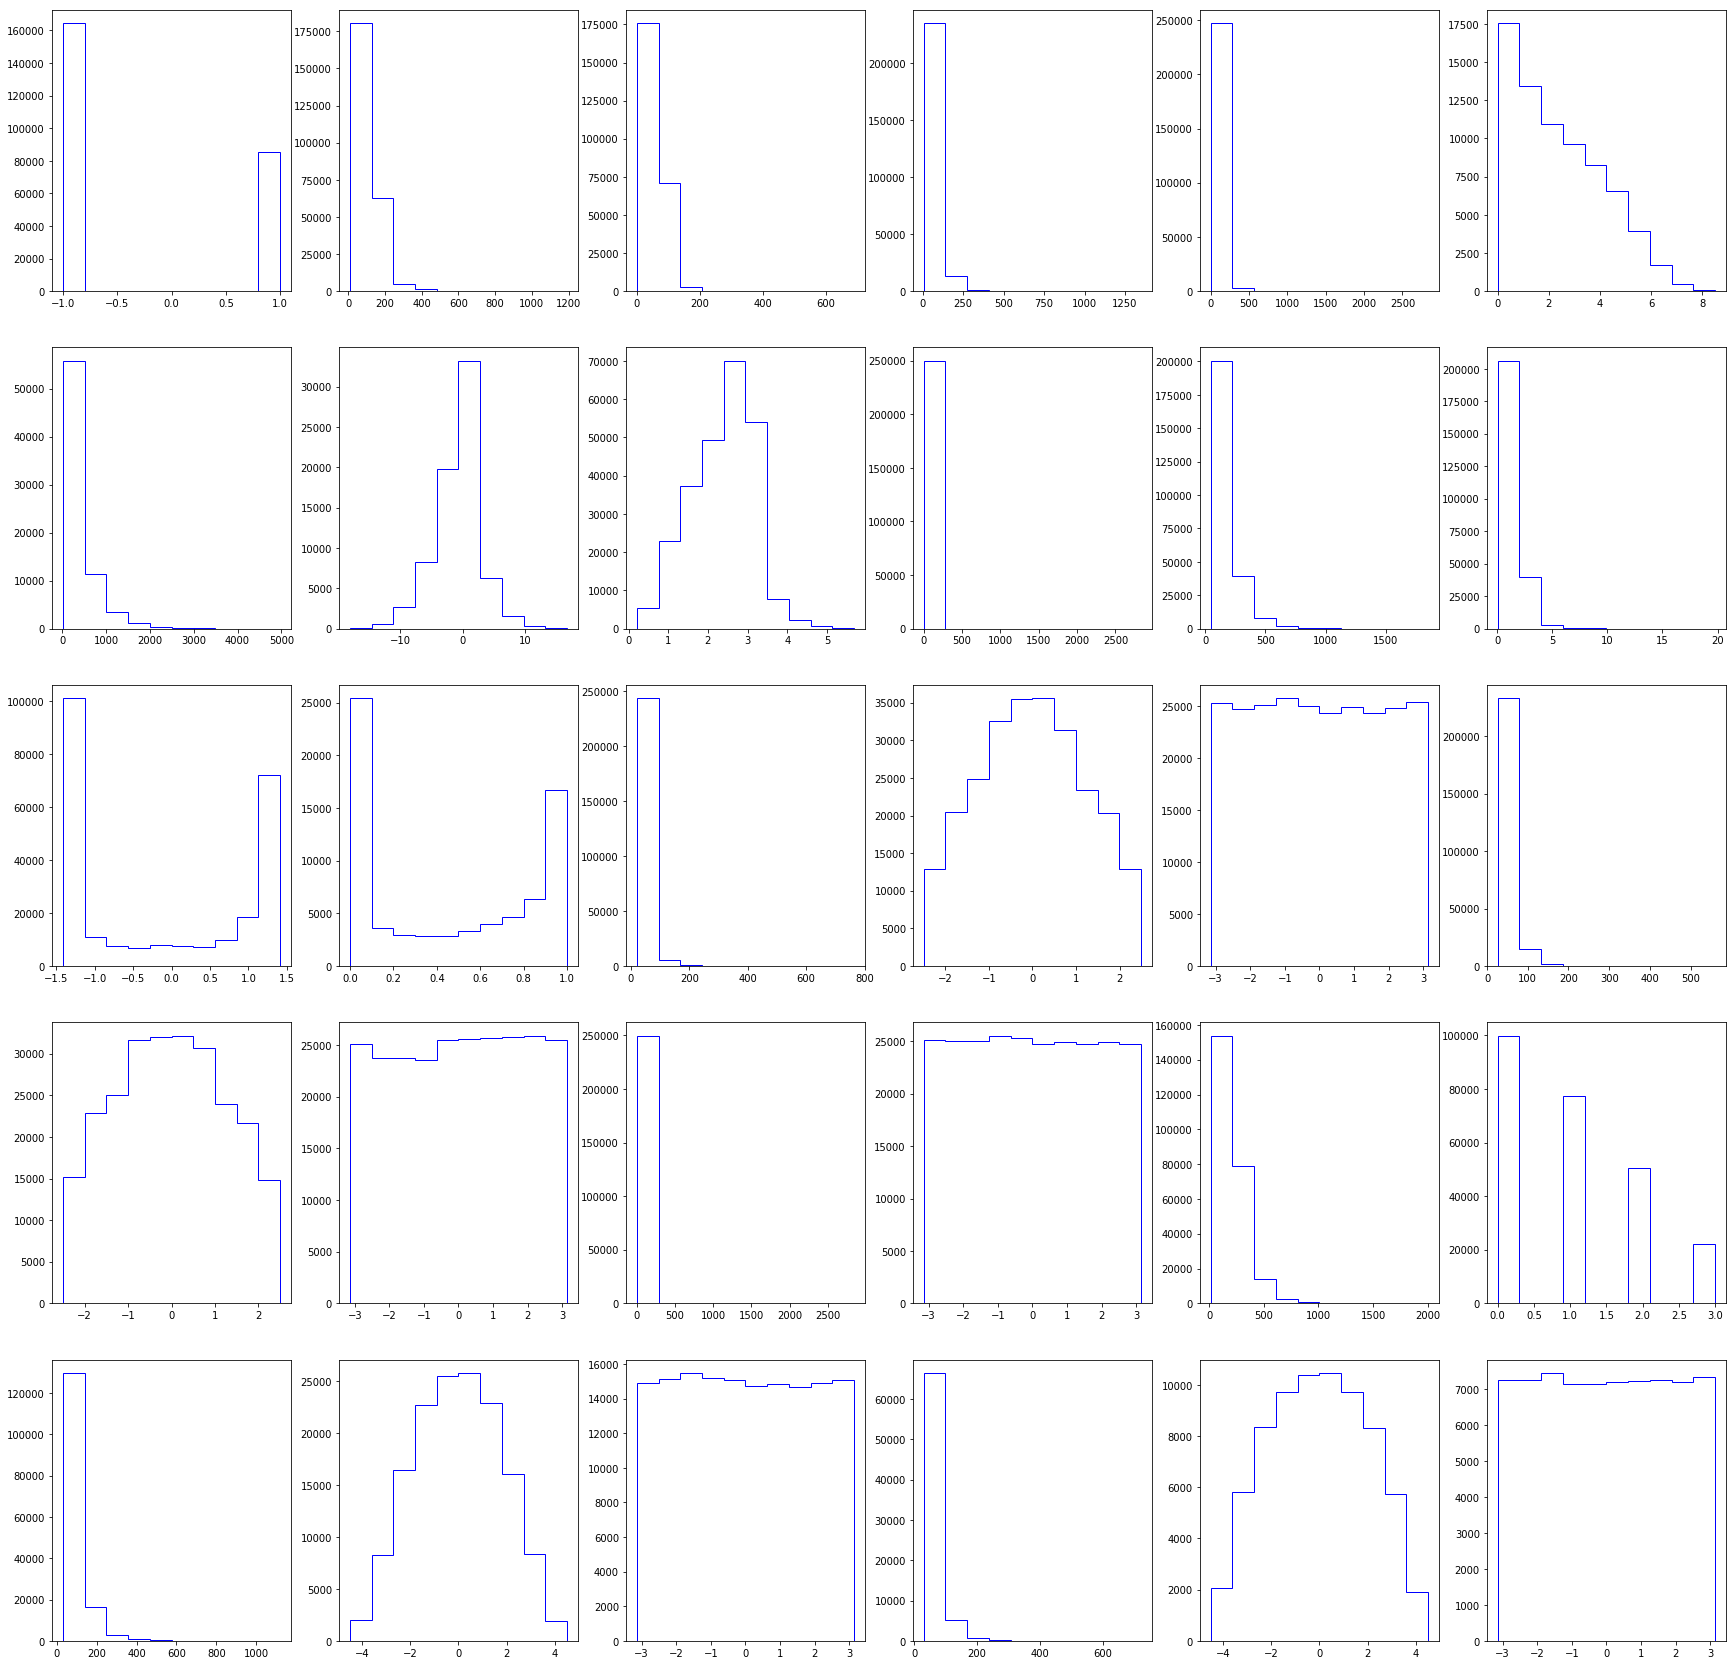

In [5]:
# plot histogram of each feature
figure, axes = plt.subplots(5, 6, facecolor='white', figsize = (30, 30))
axes = axes.ravel()

for index, axes_index in enumerate(axes):
    column = dataframe_tr.values[:,index]
    plot_data = column[np.where(column != -999)]
    axes_index.hist(plot_data, histtype = 'step', color='b')

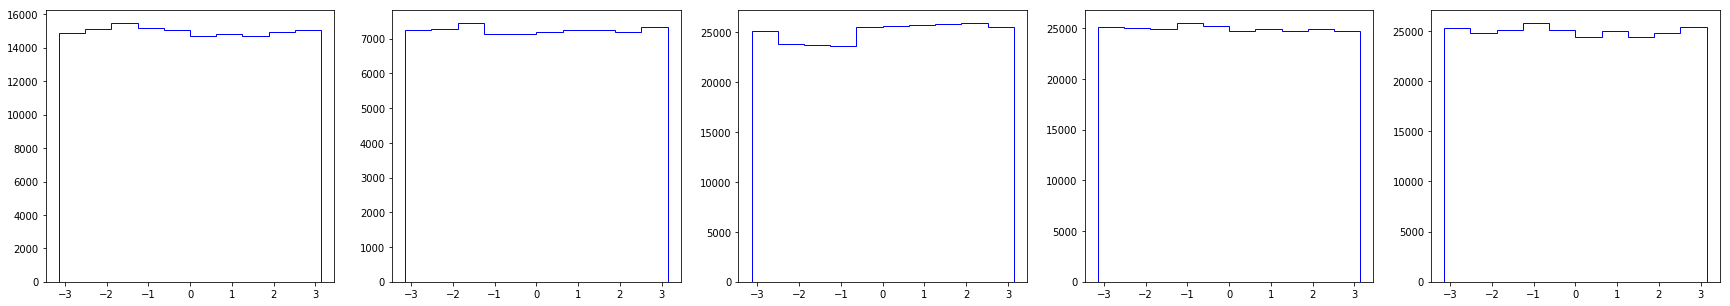

In [6]:
# drop features which are uniformly distributed
feature_dorp_phi = ['PRI_jet_leading_phi',
                    'PRI_jet_subleading_phi',
                    'PRI_lep_phi',
                    'PRI_met_phi',
                    'PRI_tau_phi',]

figure, axes = plt.subplots(1, len(feature_dorp_phi), facecolor='white', figsize = (30, 5))
axes = axes.ravel()

for index, axes_index in enumerate(axes):
    column = dataframe_tr[feature_dorp_phi[index]]
    plot_data = column[np.where(column != -999)]
    axes_index.hist(plot_data, histtype = 'step', color='b')

In [8]:
dataframe_tr = dataframe_tr.drop(feature_dorp_phi)
dataframe_tr.values.shape

(250000, 26)

### 2.2 Divide Training Data to 3 Groups

In [9]:
# divide training data to 3 groups according to feature 'PRI_jet_num'
def group_features_by_jet(dataframe):
    return {  
        0: dataframe.loc( dataframe['PRI_jet_num'] == 0).copy(),
        1: dataframe.loc( dataframe['PRI_jet_num'] == 1).copy(),
        2: dataframe.loc((dataframe['PRI_jet_num'] == 2) | (dataframe['PRI_jet_num'] == 3)).copy(),
    }
dataframe_tr_grp = group_features_by_jet(dataframe_tr)
dataframe_tr_grp[0].values

array([[  -1.   ,  143.905,   81.417, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,  175.864,   16.915, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,  105.594,   50.559, ..., -999.   , -999.   ,    0.   ],
       ...,
       [  -1.   ,   96.819,   58.179, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,   94.951,   19.362, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,   96.819,   72.756, ..., -999.   , -999.   ,    0.   ]])

### 2.3 Feature Selection

#### 2.3.1 Drop features with undefined values in each group

In [10]:
# calculate missing rate 
def missing_rate(dataframe, miss_number):
    features = dataframe.drop(['Prediction'])
    missing_rate = []
    for feature in features.labels:
        data = features.loc(features[feature] ==  miss_number)
        if data.values.size != 0:
            missing_rate.append(data[feature].size / features[feature].size)
        else:
            missing_rate.append(0)
    missing_rate = np.array(missing_rate).reshape([1, -1]).squeeze()
    missing_rate_labels = dataframe.labels[1:]
    return DataFrame(missing_rate, [0], missing_rate_labels)

# get features with undefined values
dataframe_tr_feature_undefined = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], -999)
    dataframe_tr_feature_undefined.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())
dataframe_tr_feature_undefined

[['DER_deltaeta_jet_jet',
  'DER_mass_jet_jet',
  'DER_prodeta_jet_jet',
  'DER_lep_eta_centrality',
  'PRI_jet_leading_pt',
  'PRI_jet_leading_eta',
  'PRI_jet_subleading_pt',
  'PRI_jet_subleading_eta'],
 ['DER_deltaeta_jet_jet',
  'DER_mass_jet_jet',
  'DER_prodeta_jet_jet',
  'DER_lep_eta_centrality',
  'PRI_jet_subleading_pt',
  'PRI_jet_subleading_eta'],
 []]

In [11]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_undefined[0])
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(dataframe_tr_feature_undefined[1])
# group2 have no feature with undefined values
dataframe_tr_grp[0].values

array([[ -1.   , 143.905,  81.417, ...,  86.062,   0.   ,   0.   ],
       [ -1.   , 175.864,  16.915, ...,  53.131,   0.   ,   0.   ],
       [ -1.   , 105.594,  50.559, ..., 129.804,   0.   ,   0.   ],
       ...,
       [ -1.   ,  96.819,  58.179, ...,  80.408,   0.   ,   0.   ],
       [ -1.   ,  94.951,  19.362, ..., 112.718,   0.   ,   0.   ],
       [ -1.   ,  96.819,  72.756, ...,  99.405,   0.   ,   0.   ]])

#### 2.3.2 Drop features with 0 values in each group

In [12]:
# calculate zero rate
dataframe_tr_feature_zero = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], 0)
    dataframe_tr_feature_zero.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())
dataframe_tr_feature_zero

[['PRI_jet_num', 'PRI_jet_all_pt'], [], []]

In [13]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_zero[0])
dataframe_tr_grp[0].values

array([[ -1.   , 143.905,  81.417, ...,  -0.522,  31.082,  86.062],
       [ -1.   , 175.864,  16.915, ...,   0.798,   2.723,  53.131],
       [ -1.   , 105.594,  50.559, ...,   0.21 ,  37.791, 129.804],
       ...,
       [ -1.   ,  96.819,  58.179, ...,   0.308,  46.737,  80.408],
       [ -1.   ,  94.951,  19.362, ...,  -0.874,  12.15 , 112.718],
       [ -1.   ,  96.819,  72.756, ...,   1.49 ,  40.729,  99.405]])

In [14]:
# drop feature 'PRI_jet_num' which is already used for grouping
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop('PRI_jet_num')
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop('PRI_jet_num')

#### 2.3.2 Drop features with  strong linear correlation

In [15]:
# calculate linear correlation coefficient matrix of each group
np.corrcoef(dataframe_tr_grp[0].values.T)

array([[ 1.00000000e+00,  5.15456404e-02, -4.13031710e-01,
         3.26086816e-02,  1.13075343e-02,  2.20601872e-01,
         1.13075350e-02,  1.16715777e-01, -3.33002796e-01,
         1.52441916e-01,  2.93494153e-01,  6.49608760e-03,
        -1.17910069e-01,  1.40061751e-02, -2.42971416e-01,
         1.02838776e-01],
       [ 5.15456404e-02,  1.00000000e+00,  8.39487759e-02,
         7.72494183e-01,  1.07600580e-02,  5.17625604e-01,
         1.07600621e-02,  5.68992332e-01,  6.72239151e-02,
         7.95541120e-02,  4.01125915e-01,  1.16883465e-02,
         5.00281525e-01,  6.14593905e-03, -1.69897967e-02,
         1.98240799e-01],
       [-4.13031710e-01,  8.39487759e-02,  1.00000000e+00,
         8.22945555e-02, -2.09085512e-02, -3.03469656e-01,
        -2.09085600e-02,  2.27125911e-01,  6.04801684e-01,
        -2.60863683e-01, -1.85432147e-01, -1.13168184e-02,
         5.60495239e-01, -1.39063481e-02,  6.81982523e-01,
         5.50778034e-03],
       [ 3.26086816e-02,  7.72494183e

In [16]:
def corr(self, threshold):
    corr = np.corrcoef(self.values.T)
    corr_list = []
    temp = np.array(self.labels)
    for i in range(corr.shape[0]):
        same_flag = []
        corr_coeff = temp[(corr[i] > threshold) | (corr[i] < -threshold)]
        corr_coeff = corr_coeff.tolist()
        if len(corr_coeff) > 1 and len(corr_list) != 0:
            for corr_term in corr_list:   # delete the same feature combinations
                judge_1 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_term))
                judge_2 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_coeff))
                same_flag.append(judge_1 | judge_2)
            if sum(same_flag) == 0:
                corr_list.append(corr_coeff)
        elif len(corr_coeff) > 1:
            corr_list.append(corr_coeff)
    return corr_list

# get feature combinations whose linear correlation coefficient larger than threshold
corr_grp0 = corr(dataframe_tr_grp[0], 0.7)
corr_grp1 = corr(dataframe_tr_grp[1], 0.7)
corr_grp2 = corr(dataframe_tr_grp[2], 0.7)
corr_grp0

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h', 'DER_pt_tot'],
 ['DER_sum_pt', 'PRI_tau_pt', 'PRI_lep_pt']]

In [17]:
corr_grp1

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h',
  'DER_sum_pt',
  'PRI_met_sumet',
  'PRI_jet_leading_pt',
  'PRI_jet_all_pt'],
 ['DER_pt_ratio_lep_tau', 'PRI_lep_pt']]

In [18]:
corr_grp2

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h', 'DER_sum_pt', 'PRI_met', 'PRI_jet_leading_pt'],
 ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet'],
 ['DER_pt_h',
  'DER_sum_pt',
  'PRI_met_sumet',
  'PRI_jet_leading_pt',
  'PRI_jet_subleading_pt',
  'PRI_jet_all_pt'],
 ['DER_pt_ratio_lep_tau', 'PRI_lep_pt']]

In [19]:
# drop features with strong linear correlation
feature_dorp_corr0 = list(['DER_mass_MMC','DER_pt_tot','PRI_tau_pt','PRI_lep_pt'])
feature_dorp_corr1 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])
feature_dorp_corr2 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])

dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(feature_dorp_corr0)
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(feature_dorp_corr1)
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop(feature_dorp_corr2)

In [32]:
# ridge_regression using cv
w = []
acc_tr = []
acc_te = []
lambda_ = 0.0001
k_fold = 10
seed = 10

for i in range(len(dataframe_tr_grp)):
    x = dataframe_tr_grp[i].drop('Prediction').values
    x = log_process(x)
    x = build_polynomial_features(x,3)
    x_tr,_,_ = standardize(x)
    y_tr = (dataframe_tr_grp[i])['Prediction']
    w_tmp,acc_tr_tmp,acc_te_tmp = cv_loop(y_tr, x_tr,k_fold,seed,ridge_regression,lambda_=lambda_)
    w.append(w_tmp)
    acc_tr.append(acc_tr_tmp)
    acc_te.append(acc_te_tmp)

In [33]:
acc_tr

[0.840538466671115, 0.7950623298466829, 0.8202514971894193]